## Task - 4 Welcome to Similarity Search
Big Techs usually do image search or any search in general using the principle of randomness and least sensitive hashing. Well in the class we have studied that CNN’s are one of the best feature extractors. My curious brains wonders if we can use this to build a similarity based search engine to do a particular task . My proposal is to re-use the CNN model in task-1, to extract the feature vectors from the images and use these feature vectors to build a similarity search engine. You will need to use a vectordb (like postgres with the pgvector extension or qdrant) to store these feature vectors. Once your feature vectors are ready , we want you to select 3 random images and retrieve the top-k similar images from the database. Please assign a number of your choice to the variable k . For every image that is retrieved display the retrieved image and its similarity score.

## Loading DS + Model

In [2]:
!pip install captum qdrant_client datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 124.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


### Import Libraries
Import all necessary libraries for PyTorch, data loading, visualization, and Qdrant vector database.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from datasets import load_dataset
from captum.attr import LayerGradCam, LayerAttribution, Occlusion
import matplotlib.cm as cm
import os
import math

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct

### Load Dataset
Load the cats vs dogs dataset from HuggingFace.


In [4]:
ds = load_dataset("pantelism/cats-vs-dogs")

print(f"Dataset loaded: {len(ds['train'])} images in train split")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

Dataset loaded: 4000 images in train split


### Define and Load Model
Define the SimpleCNN architecture with residual blocks and load the pre-trained weights from Task 1.


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "cnn_weights.pth"

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + x)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, p_drop=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(256),
            nn.Conv2d(256, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2),
            ResidualBlock(512),
            nn.Conv2d(512, 512, 3, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

model = SimpleCNN()
obj = torch.load(MODEL_PATH, map_location=device)
if isinstance(obj, dict):
    model.load_state_dict(obj, strict=False)
else:
    model = obj
model.to(device).eval()

print("model loaded")


model loaded


## Similarity Search

### Configuration
Set up similarity search parameters including collection name, top-k value, number of images to index, image size, and random seed.


In [6]:
COLLECTION = "cnn_catsdogs_vectors"
K          = 5
MAX_INDEX  = 1200
IMG_SIZE   = 224
SEED       = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

### Prepare Dataset for Inference
Create transforms and a custom dataset wrapper that returns both normalized tensors for inference and unnormalized images for visualization.


In [7]:
infer_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])
vis_tfms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE))])

class HFDatasetWrapped(Dataset):
    def __init__(self, split, infer_tfm, vis_tfm):
        self.split = split
        self.infer_tfm = infer_tfm
        self.vis_tfm = vis_tfm
    def __len__(self): return len(self.split)
    def __getitem__(self, i):
        pil = self.split[i]["image"].convert("RGB")
        x = self.infer_tfm(pil)
        x_vis = np.array(self.vis_tfm(pil))
        y = int(self.split[i]["label"])
        return x, y, x_vis

assert 'ds' in globals(), "Expected your dataset object `ds` (HF DatasetDict) to be defined."
split = ds["test"] if "test" in ds else ds["train"]
dataset = HFDatasetWrapped(split, infer_tfms, vis_tfms)

N_index = min(len(dataset), MAX_INDEX)
subset_idx = np.random.permutation(len(dataset))[:N_index].tolist()
loader = DataLoader(torch.utils.data.Subset(dataset, subset_idx),
                    batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

### Extract Feature Embeddings
Create an embedder that extracts 512-dimensional feature vectors from the CNN (before the classification layer) and extract embeddings for all images in the dataset.


In [8]:
class CNNEmbedder(nn.Module):
    def __init__(self, trunk):
        super().__init__()
        self.backbone = trunk
    def forward(self, x):
        z = self.backbone.features(x)
        z = self.backbone.avgpool(z)
        z = torch.flatten(z, 1)
        z = self.backbone.dropout(z)
        return z

embedder = CNNEmbedder(model).to(device).eval()

@torch.no_grad()
def extract_embeddings(dataloader):
    vecs, labels, thumbs = [], [], []
    for xb, yb, xvis in dataloader:
        xb = xb.to(device)
        z = embedder(xb)
        z = F.normalize(z, p=2, dim=1)
        vecs.append(z.cpu().numpy())
        labels.extend([int(y) for y in yb])
        thumbs.extend([img for img in xvis])
    V = np.concatenate(vecs, axis=0).astype(np.float32)
    return V, np.array(labels), np.stack(thumbs, axis=0)

V, y_idx, thumbs = extract_embeddings(loader)
N, D = V.shape
print(f"Indexed {N} vectors of dim {D}.")


Indexed 1200 vectors of dim 512.


### Setup Qdrant Vector Database
Initialize in-memory Qdrant client, create a collection with cosine similarity, and upload all feature vectors.


In [9]:
client = QdrantClient(":memory:")

client.recreate_collection(
    collection_name=COLLECTION,
    vectors_config=VectorParams(size=D, distance=Distance.COSINE)
)

points = [
    PointStruct(
        id=int(i),
        vector=V[i].tolist(),
        payload={"label": int(y_idx[i]), "i": int(i)}
    )
    for i in range(N)
]
client.upsert(collection_name=COLLECTION, points=points)
print("Upserted embeddings to in-memory Qdrant.")


/tmp/ipython-input-1625828917.py:3: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


Upserted embeddings to in-memory Qdrant.


### Query and Display Results
Select 3 random query images and retrieve the top-k most similar images from the database, displaying both the query and similar images with their similarity scores.



Top-5 similar images via in-memory Qdrant (cosine):

Query idx=228 (label=1) → [(id, score), ...]:
[(228, 1.000000015026659), (86, 0.9988994421531542), (825, 0.9985982968879272), (1149, 0.9976529381570347), (333, 0.9976305275413686)]


/tmp/ipython-input-3504858825.py:20: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  res = client.search(collection_name=COLLECTION,


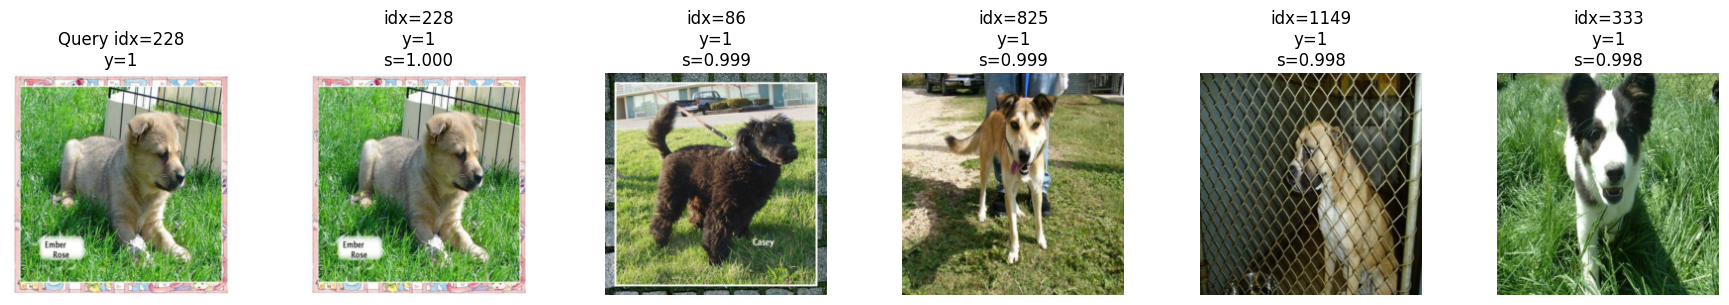


Query idx=51 (label=1) → [(id, score), ...]:
[(51, 0.9999999761354456), (93, 0.9980354201313271), (161, 0.997574707761931), (998, 0.9974089447211801), (920, 0.9959288110587262)]


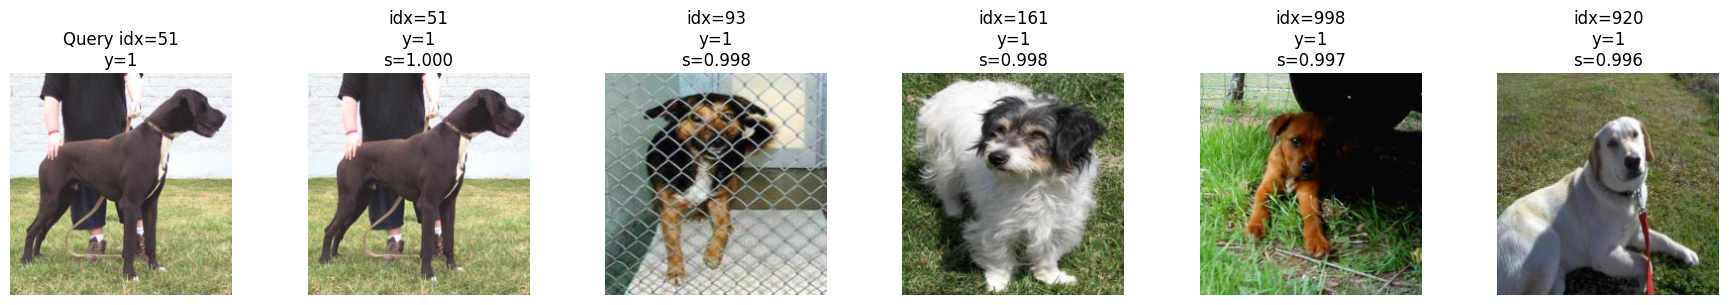


Query idx=563 (label=0) → [(id, score), ...]:
[(563, 1.0000000251929864), (1002, 0.9988425563205716), (527, 0.9985866356342984), (542, 0.9984811410739489), (591, 0.9984674518746764)]


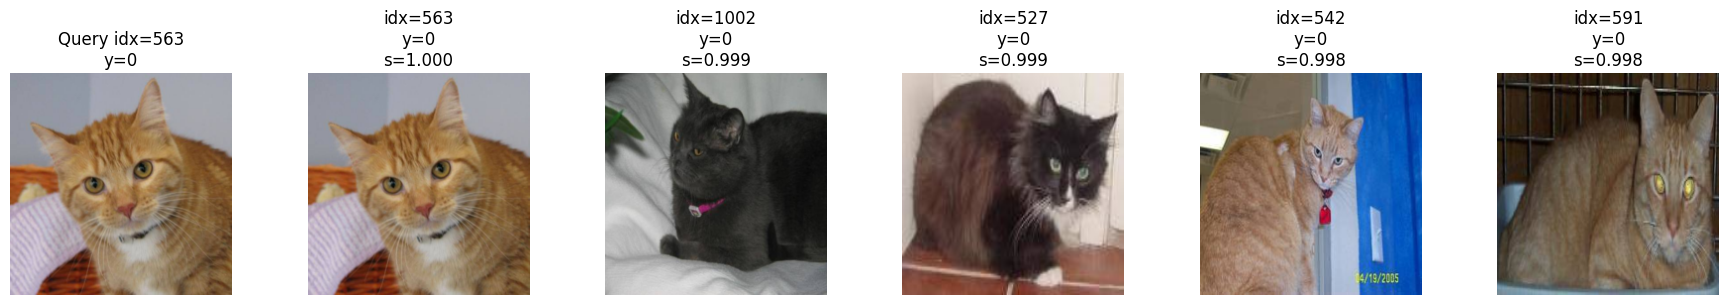

In [10]:
def show_results(query_idx, neighbors):
    q_img = thumbs[query_idx]
    q_lab = y_idx[query_idx]
    cols = K + 1
    plt.figure(figsize=(3*cols, 3))
    ax = plt.subplot(1, cols, 1)
    ax.imshow(q_img); ax.axis("off")
    ax.set_title(f"Query idx={query_idx}\ny={q_lab}")
    for j, p in enumerate(neighbors, start=2):
        nid = int(p.id)
        score = float(p.score)
        ax = plt.subplot(1, cols, j)
        ax.imshow(thumbs[nid]); ax.axis("off")
        ax.set_title(f"idx={nid}\ny={y_idx[nid]}\ns={score:.3f}")
    plt.tight_layout(); plt.show()

query_indices = random.sample(range(N), 3)
print(f"\nTop-{K} similar images via in-memory Qdrant (cosine):")
for qi in query_indices:
    res = client.search(collection_name=COLLECTION,
                        query_vector=V[qi].tolist(),
                        limit=K)
    print(f"\nQuery idx={qi} (label={y_idx[qi]}) → [(id, score), ...]:")
    print([(int(p.id), float(p.score)) for p in res])
    show_results(qi, res)
